The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[INFO] Loaded 25 descriptor(s) from ./mapping_schemes
[DEBUG] Using top‐level group: subject-1
[DEBUG] Segment timestamps: ['2022-03-28 20:03:52.303544', '2022-03-28 20:04:23.921393', '2022-03-28 20:04:39.471830', '2022-03-28 20:04:54.725031', '2022-03-28 20:05:07.199116', '2022-03-28 20:05:20.677248', '2022-03-28 20:06:45.146903', '2022-03-28 20:07:01.673154', '2022-03-28 20:07:15.862736', '2022-03-28 20:07:28.793519', '2022-03-28 20:07:51.924452', '2022-03-28 20:08:04.314577', '2022-03-28 20:08:16.658126', '2022-03-28 20:08:26.934290', '2022-03-28 20:08:39.813661', '2022-03-28 20:08:51.384581', '2022-03-28 20:09:03.922868', '2022-03-28 20:09:27.114219', '2022-03-28 20:10:46.448582', '2022-03-28 20:11:00.539328', '2022-03-28 20:11:26.925831', '2022-03-28 20:11:51.607512', '2022-03-28 20:12:29.815367', '2022-03-28 20:13:10.028880']
[DEBUG] Shapes:
 - ECG:    (3, 599996), time length (599996,)
 - HR:

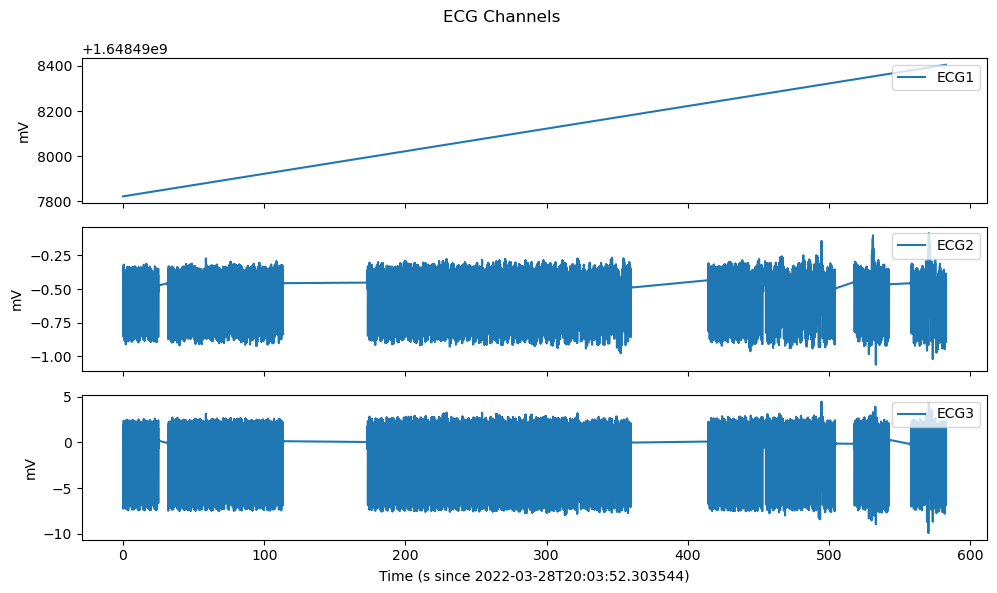

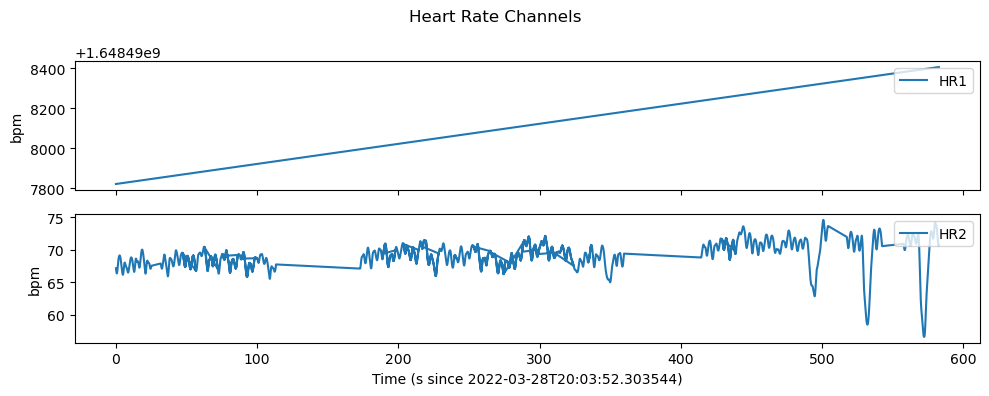

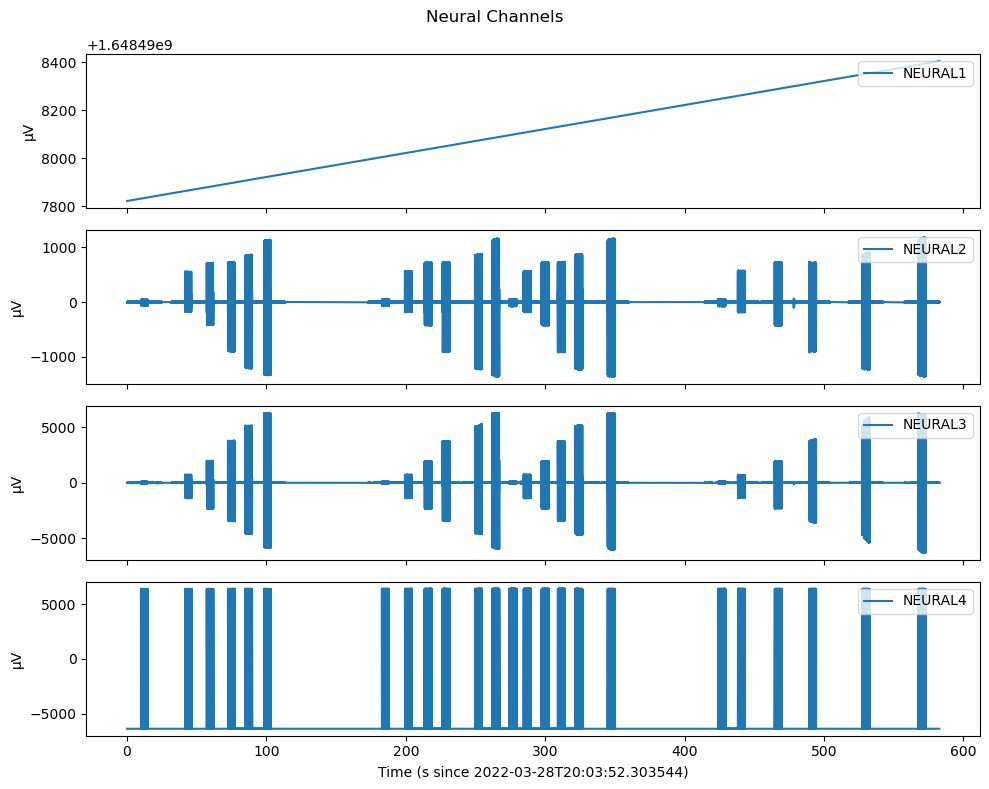

✅ Saved standardized data to: output\subject-1.npz


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 3

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from datetime import datetime
from utils import match_best_mapping, load_all_descriptors, save_standardized_output

# 1) Load descriptors & map file
descriptors = load_all_descriptors()
filepath    = "./downloads/subject-1.hdf5"
filename    = Path(filepath).name

result = match_best_mapping(descriptors, filepath, sparc_id=349)
if result["descriptor"] is None:
    raise RuntimeError("No suitable mapping descriptor found.")

print("Selected mapping:", result['descriptor']['id'])
print("Score:", result['score'])

res = result["result"]
meta = res["metadata"]

# 2) Unpack each modality
ecg    = res["signals"]           # shape (3, N_ecg)
t_ecg  = res["time"]              # length N_ecg

hr     = res["signals_hr"]        # shape (2, N_hr)
t_hr   = res["time_hr"]           # length N_hr

neural = res["signals_neural"]    # shape (4, N_neural)
t_neu  = res["time_neural"]       # length N_neural

# 3) Plot ECG (3 channels)
fig, axes = plt.subplots(ecg.shape[0], 1, sharex=True, figsize=(10, 2*ecg.shape[0]))
for i, ax in enumerate(axes):
    ax.plot(t_ecg, ecg[i], label=f"ECG{i+1}")
    ax.set_ylabel("mV")
    ax.legend(loc="upper right")
axes[-1].set_xlabel(f"Time (s since {meta['start_time']})")
fig.suptitle("ECG Channels")
plt.tight_layout()
plt.show()

# 4) Plot HR (2 channels)
fig, axes = plt.subplots(hr.shape[0], 1, sharex=True, figsize=(10, 2*hr.shape[0]))
for i, ax in enumerate(axes):
    ax.plot(t_hr, hr[i], label=f"HR{i+1}")
    ax.set_ylabel("bpm")
    ax.legend(loc="upper right")
axes[-1].set_xlabel(f"Time (s since {meta['start_time']})")
fig.suptitle("Heart Rate Channels")
plt.tight_layout()
plt.show()

# 5) Plot Neural (4 channels)
fig, axes = plt.subplots(neural.shape[0], 1, sharex=True, figsize=(10, 2*neural.shape[0]))
for i, ax in enumerate(axes):
    ax.plot(t_neu, neural[i], label=f"NEURAL{i+1}")
    ax.set_ylabel("µV")
    ax.legend(loc="upper right")
axes[-1].set_xlabel(f"Time (s since {meta['start_time']})")
fig.suptitle("Neural Channels")
plt.tight_layout()
plt.show()

# 6) Save to .npz
output_dir = Path("./output")
output_dir.mkdir(exist_ok=True, parents=True)
outpath = output_dir / filename.replace(".hdf5", ".npz")

save_standardized_output(
    output_path=outpath,
    result_dict=res,
    descriptor=result["descriptor"],
    original_filename=filename,
    annotations=res.get("annotations", []),
    metadata_overrides=None,
    file_format="npz"
)
print(f"✅ Saved standardized data to: {outpath}")


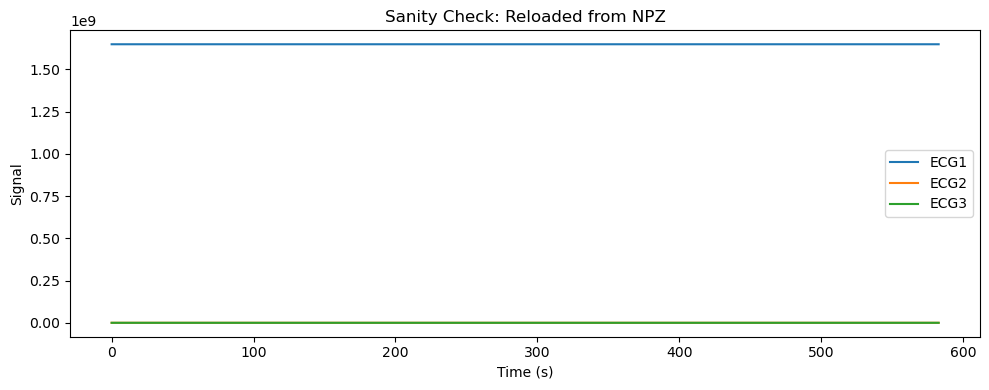

{'time_units': 'seconds', 'time_auto_generated': False, 'source_format': '.hdf5', 'database_id': 'unknown', 'sampling_frequency': 1000.0, 'channel_names': ['ECG1', 'ECG2', 'ECG3'], 'channel_units': ['unknown', 'unknown', 'unknown'], 'version': 'v1.0', 'upload_date': '2025-07-30', 'conversion_date': '2025-07-30', 'auto_mapped': True, 'doi': 'unknown', 'original_file_name': 'subject-1.hdf5', 'sparc_subject_id': 'unknown', 'species': 'unknown', 'anatomical_location': 'unknown', 'modality': 'unknown', 'experimenter': ['unknown'], 'institution': 'unknown', 'sweep_mode': False, 'notes': 'Mapped using SPARCFUSE'}
shape of time: (599996,)
shape of signals: (3, 599996)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load the .npz file
npz_path = Path("./output/subject-1.npz")
data = np.load(npz_path, allow_pickle=True)

# Extract arrays
time = data["time"]
signals = data["signals"]
metadata = data["metadata"].item()  # metadata is saved as a Python dict
channel_names = metadata.get("channel_names", [f"CH{i+1}" for i in range(len(signals))])

# Plot
plt.figure(figsize=(10, 4))
for i, ch in enumerate(signals):
    plt.plot(time, ch, label=channel_names[i])
plt.xlabel("Time (s)")
plt.ylabel("Signal")
plt.title("Sanity Check: Reloaded from NPZ")
plt.legend()
plt.tight_layout()
plt.show()

print(data['metadata'])

print("shape of time:", time.shape)
print("shape of signals:", signals.shape)

In [ ]:
# In a Jupyter notebook cell:

import h5py

def print_hdf5_structure(group, indent=0):
    """
    Recursively print the members of an HDF5 group or file.
    - group:    an h5py.File or h5py.Group object
    - indent:   current indentation level (spaces)
    """
    for name, item in group.items():
        prefix = ' ' * indent
        if isinstance(item, h5py.Group):
            print(f"{prefix}Group:    {name}/")
            print_hdf5_structure(item, indent + 4)
        elif isinstance(item, h5py.Dataset):
            print(f"{prefix}Dataset:  {name}    shape={item.shape}    dtype={item.dtype}")
        else:
            print(f"{prefix}Unknown:  {name}    type={type(item)}")

# Usage
hdf5_path = "./downloads/subject-1.hdf5"   # ← replace with your HDF5 filename
with h5py.File(hdf5_path, "r") as f:
    print(f"Contents of {hdf5_path}:")
    print_hdf5_structure(f)
